## Load Packages and Data 

In [10]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random as random
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [11]:
from LSTM_helper import *

In [12]:
spy = pd.read_csv("spy_full.csv")
spy_week = pd.read_csv("spy_week.csv")
spy_month = pd.read_csv("spy_month.csv")

## Set Up GPU for model training 

* Ensure that the GPU is readily available
* Fix a seed for training and set the CUDA environment to be deterministic to ensure the results are reproducible. 

In [14]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU environments
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA version:", torch.version.cuda)
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Count:", torch.cuda.device_count())
    device = torch.device("cuda")  # Set device to GPU
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


## Examine data 

In [16]:
spy_month['date'] = pd.to_datetime(spy['date'])
initial_price = spy_month['close_price'].iloc[-1]
spy_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           383 non-null    datetime64[ns]
 1   close_price    383 non-null    float64       
 2   simple_return  383 non-null    float64       
 3   log_return     383 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 12.1 KB


## Setting up model training 
* Defines the necessary variables for train test split 
* Ensures that the training and test data are split sequentially
* Converts all training and test sets into tensors for GPU to process
* Create the model 

In [18]:
# Extract log returns and initialize parameters
log_returns = spy_month['log_return']
seq_length = 120  # Number of months in each sequence
initial_price = spy_month['close_price'].iloc[-1]  # Last known price

# Create sequences from log returns
X, y = create_sequences(log_returns.values, seq_length)

# Compute train-test split sizes
total_sequences = len(X)
train_size = int(total_sequences * 0.8)  # 80% for training
test_size = total_sequences - train_size  # 20% for testing

# Split the data sequentially for time series
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)  # Shape: (train_size, seq_length, input_size)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (train_size, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)  # Shape: (test_size, seq_length, input_size)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (test_size, 1)

# Ensure model is on the correct device
model = SPYLSTM(input_size=1, hidden_size=50, output_size=1, num_layers=2, dropout=0.2).to(device)

# Print dataset sizes for confirmation
print(f"Total sequences: {total_sequences}")
print(f"Training size: {train_size}, Testing size: {test_size}")

Total sequences: 263
Training size: 210, Testing size: 53


## Train the model 



In [20]:
# Training loop
num_epochs = 550
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create a DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size of 32

# Initialize list to store loss values for plotting
loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    # Append epoch loss to history
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/550, Loss: 0.0285
Epoch 2/550, Loss: 0.0217
Epoch 3/550, Loss: 0.0193
Epoch 4/550, Loss: 0.0168
Epoch 5/550, Loss: 0.0191
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/203.1 MB 10.9 MB/s eta 0:00:19
   ---------------------------------------- 1.1/203.1 MB 14.0 MB/s eta 0:00:15
   ---------------------------------------- 1.9/203.1 MB 15.5 MB/s eta 0:00:13
    --------------------------------------- 2.9/203.1 MB 16.7 MB/s eta 0:00:13
    --------------------------------------- 3.6/203.1 MB 17.9 MB/s eta 0:00:12
    --------------------------------------- 3.8/203.1 MB 14.2 MB/s eta 0:00:15
    --------------------------------------- 3.9/203.1 MB 12.5 MB/s eta 0:00:16
    --------------------------------------- 4.0/203.1 MB 11.2 MB/s eta 0:00:18
    --------------------------------------- 4.1/203.1 MB 10.5 MB/s eta 0:00:19
    --------------------------------------- 4.1/203.1 MB 10.5 MB/s eta 0:00:19
    -----

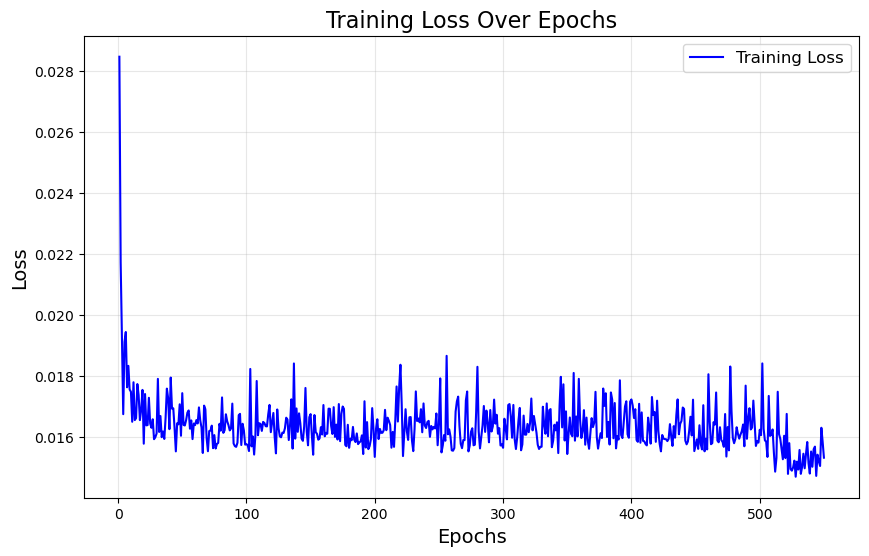

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label="Training Loss", color='blue')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Test the model 

In [23]:
# Testing the model
model.eval()  # Set the model to evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    outputs = model(X_test)  # Forward pass on the test set
    test_loss = criterion(outputs, y_test)  # Compute test loss

print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0022


## Make predictions in the next 20 years

In [25]:
# Convert log_returns to a NumPy array
log_returns = spy['log_return'].values 

# Forecast the next 20 years (~240 months)
initial_sequence = log_returns[-seq_length:]  # Use the last 250 monthly log returns as input
steps = 20 * 12  # Forecast Next 240 months 

mean_log_returns, lower_log_returns, upper_log_returns = forecast_with_ci(
    model, initial_sequence, steps, num_simulations=100
)

initial_price = spy['close_price'].iloc[-1]  # Last known price
mean_prices = log_returns_to_prices(mean_log_returns, initial_price)
lower_prices = log_returns_to_prices(lower_log_returns, initial_price)
upper_prices = log_returns_to_prices(upper_log_returns, initial_price)

# Display the last 10 forecasted log returns
print("Mean Log Returns (last 10 months):", mean_log_returns[-10:].cpu().numpy())
print("Lower Bound Log Returns (last 10 months):", lower_log_returns[-10:].cpu().numpy())
print("Upper Bound Log Returns (last 10 months):", upper_log_returns[-10:].cpu().numpy())

# Display the last 10 forecasted prices
print("Mean Prices (last 10 months):", mean_prices[-10:].cpu().numpy())
print("Lower Bound Prices (last 10 months):", lower_prices[-10:].cpu().numpy())
print("Upper Bound Prices (last 10 months):", upper_prices[-10:].cpu().numpy())

Mean Log Returns (last 10 months): [0.00705259 0.00719469 0.00708815 0.00689944 0.0072196  0.00701222
 0.00709427 0.00687745 0.00684938 0.00764573]
Lower Bound Log Returns (last 10 months): [0.00335388 0.00282194 0.00336519 0.00275364 0.00390447 0.00344819
 0.00276531 0.00320826 0.00315681 0.00370764]
Upper Bound Log Returns (last 10 months): [0.01075129 0.01156744 0.01081111 0.01104523 0.01053473 0.01057624
 0.01142324 0.01054665 0.01054195 0.01158381]
Mean Prices (last 10 months): [3033.9707 3055.8784 3077.6155 3098.9229 3121.3767 3143.3413 3165.7205
 3187.5679 3209.4753 3234.108 ]
Lower Bound Prices (last 10 months): [1251.973  1255.511  1259.7432 1263.2168 1268.1587 1272.5391 1276.0629
 1280.1635 1284.2109 1288.9812]
Upper Bound Prices (last 10 months): [7352.3774 7437.921  7518.769  7602.276  7682.787  7764.4736 7853.677
 7936.9453 8021.0586 8114.5127]


## Visualise returns

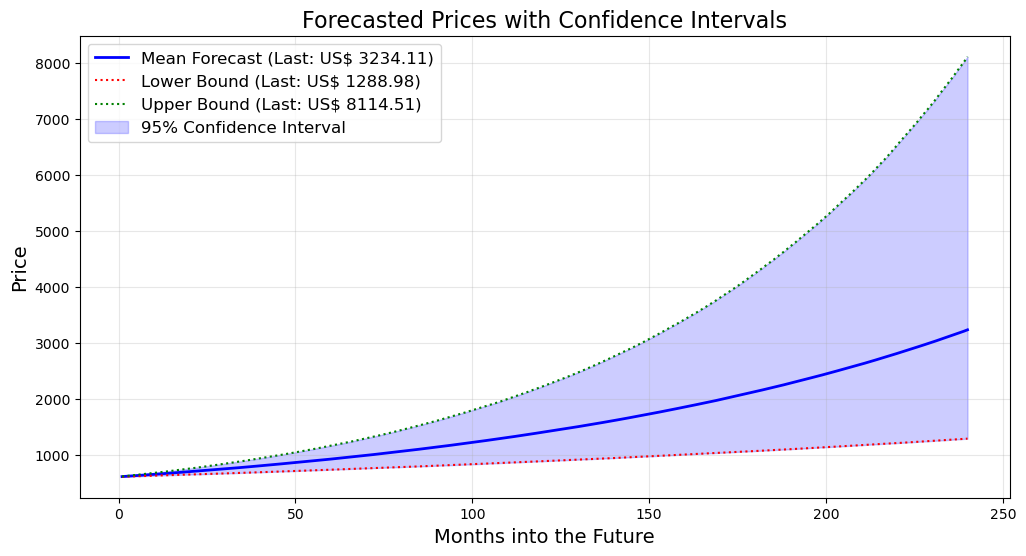

In [27]:
plot_forecast(mean_prices, lower_prices, upper_prices, steps=240)

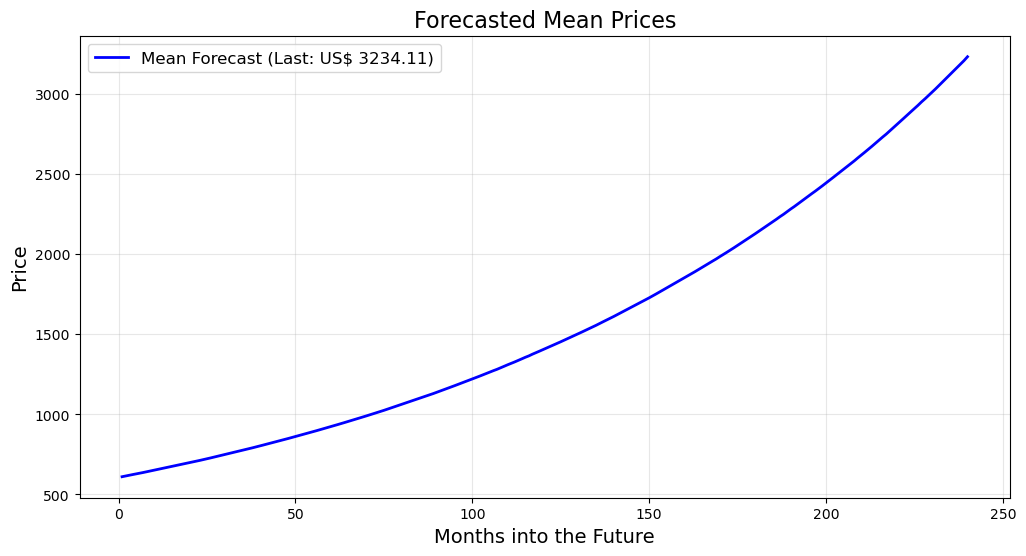

In [28]:
plot_mean_forecast(mean_prices, steps=240)